In [1]:
# 1) Install dependencies
!pip install ultralytics --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 27.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 whic

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import random
from tqdm.auto import tqdm
from tqdm import tqdm
import shutil as sh
random.seed(10)
%matplotlib inline
import glob

2025-04-21 01:48:23.905953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745200104.101735      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745200104.156568      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
csv_path1 = "/kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/image_data.csv"
df = pd.read_csv(csv_path1)
print(df.head())

   Unnamed: 0      img_id  x_min  y_min  x_max  y_max  classes
0           0  037927.jpg    4.0  390.0  109.0  512.0        0
1           1  052817.jpg    0.0    0.0    0.0    0.0        1
2           2  075438.jpg    0.0    0.0    0.0    0.0        1
3           3  020459.jpg  204.0  110.0  512.0  331.0        0
4           4  044340.jpg  491.0  368.0  512.0  406.0        0


In [4]:
csv_path2 = "/kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/image_df.csv"
img_df = pd.read_csv(csv_path2)
print(df.head())

   Unnamed: 0      img_id  x_min  y_min  x_max  y_max  classes
0           0  037927.jpg    4.0  390.0  109.0  512.0        0
1           1  052817.jpg    0.0    0.0    0.0    0.0        1
2           2  075438.jpg    0.0    0.0    0.0    0.0        1
3           3  020459.jpg  204.0  110.0  512.0  331.0        0
4           4  044340.jpg  491.0  368.0  512.0  406.0        0


In [5]:
defective = img_df[img_df['defective_mode'] == 'yes']
print(len(defective))

23706


In [6]:
defective_idx = list(defective['img_name'])
defective_idx = defective_idx[:]
print(len(defective_idx))

23706


In [7]:
random.seed(10)
test_def = random.sample(defective_idx, int(len(defective_idx)*0.20))
print(len(test_def))
test_idx = test_def

4741


In [8]:
train_def_idx = [x for x in defective_idx if x not in test_def]
train_idx = train_def_idx
len(train_idx)

18965

In [9]:
random.seed(10)
val_idx = random.sample(train_idx, int(len(train_idx)*0.2))
train_idx = [x for x in train_idx if x not in val_idx]
print(len(val_idx), len(train_idx))

3793 15172


In [10]:
res_df = df[df['img_id'].isin(defective_idx)]
len(res_df)

35675

In [ ]:
# note: the code is from https://www.kaggle.com/code/devapandey/fdduyolov8  
im_h, im_w, num_chanels = 512, 512, 3
df["x_center"] = (df["x_max"] + df["x_min"])/2
df["y_center"] = (df["y_max"] + df["y_min"])/2
df["w"] = df["x_max"] - df["x_min"]
df["h"] = df["y_max"] - df["y_min"]
#Normalizing the values with image height and width
df["x_center"] = df["x_center"]/im_w
df["w"] = df["w"]/im_w
df["y_center"] = df["y_center"]/im_h
df["h"] = df["h"]/im_h
df

,Unnamed: 0,img_id,x_min,y_min,x_max,y_max,classes,x_center,y_center,w,h
0,0,037927.jpg,4.0,390.0,109.0,512.0,0,0.110352,0.880859,0.205078,0.238281
1,1,052817.jpg,0.0,0.0,0.0,0.0,1,0.000000,0.000000,0.000000,0.000000
2,2,075438.jpg,0.0,0.0,0.0,0.0,1,0.000000,0.000000,0.000000,0.000000
3,3,020459.jpg,204.0,110.0,512.0,331.0,0,0.699219,0.430664,0.601562,0.431641
4,4,044340.jpg,491.0,368.0,512.0,406.0,0,0.979492,0.755859,0.041016,0.074219
...,...,...,...,...,...,...,...,...,...,...,...
106797,106797,064106.jpg,0.0,0.0,0.0,0.0,1,0.000000,0.000000,0.000000,0.000000
106798,106798,001504.jpg,0.0,0.0,0.0,0.0,1,0.000000,0.000000,0.000000,0.000000
106799,106799,053364.jpg,0.0,0.0,0.0,0.0,1,0.000000,0.000000,0.000000,0.000000
106800,106800,061468.jpg,0.0,0.0,0.0,0.0,1,0.000000,0.000000,0.000000,0.000000


In [12]:
%%writefile dataset.yaml
path: /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data
train: /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/images/train
val: /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/images/val
test: /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/images/test

names:
    0: defective

Writing dataset.yaml


In [13]:
import warnings

warnings.filterwarnings("ignore")

In [14]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.111 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6281.7/8062.4 GB disk)


In [15]:
model = YOLO("yolov8s.pt")
model.train(data="dataset.yaml", epochs=20)

100%|██████████| 21.5M/21.5M [00:00<00:00, 96.2MB/s]


Ultralytics 8.3.111 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=dataset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=No

100%|██████████| 755k/755k [00:00<00:00, 23.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 112MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.0 ms, read: 5.4±0.9 MB/s, size: 53.0 KB)


train: Scanning /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/labels/train... 10630 images, 0 backgrounds, 8869 corrupt: 100%|██████████| 10631/10631 [01:16<00:00, 139.34it/s]

train: WARNING ⚠️ /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/images/train/000001.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/images/train/000002.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/images/train/000003.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/images/train/000004.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/images/train/000005.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible c

train: WARNING ⚠️ Cache directory /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6.5±1.6 MB/s, size: 50.7 KB)


val: Scanning /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/labels/val... 587 images, 0 backgrounds, 0 corrupt: 100%|██████████| 587/587 [00:04<00:00, 131.13it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/labels is not writeable, cache not saved.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.33G      1.937      2.766      1.854          7        640: 100%|██████████| 111/111 [00:34<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.40it/s]


                   all        587        966      0.179      0.258      0.115     0.0399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.35G      2.058      2.318      1.983          5        640: 100%|██████████| 111/111 [00:33<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.18it/s]


                   all        587        966      0.116     0.0839     0.0256    0.00848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.35G      2.043      2.206      1.953          8        640: 100%|██████████| 111/111 [00:32<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.13it/s]


                   all        587        966      0.281      0.269       0.18     0.0627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      4.35G      1.983      2.159      1.931          8        640: 100%|██████████| 111/111 [00:32<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.15it/s]


                   all        587        966      0.308      0.213      0.165     0.0567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      4.35G      1.932       1.97      1.851          7        640: 100%|██████████| 111/111 [00:32<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.22it/s]

                   all        587        966       0.53       0.44      0.458      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      4.35G      1.873      1.962      1.829          4        640: 100%|██████████| 111/111 [00:32<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.20it/s]

                   all        587        966      0.567      0.455      0.475       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      4.35G      1.836      1.898      1.813          4        640: 100%|██████████| 111/111 [00:32<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.25it/s]

                   all        587        966      0.484       0.34      0.339      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      4.35G      1.765      1.787      1.743          5        640: 100%|██████████| 111/111 [00:32<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.20it/s]

                   all        587        966      0.653      0.533      0.572      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      4.35G      1.739      1.759      1.725          2        640: 100%|██████████| 111/111 [00:32<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.08it/s]


                   all        587        966      0.574      0.348      0.376      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.35G      1.705      1.717      1.697          5        640: 100%|██████████| 111/111 [00:32<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.21it/s]

                   all        587        966      0.698      0.528      0.588      0.285


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.35G      1.836      1.723      1.848          1        640: 100%|██████████| 111/111 [00:33<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.15it/s]

                   all        587        966      0.602       0.49      0.488      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.35G      1.775      1.713      1.788          2        640: 100%|██████████| 111/111 [00:32<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.32it/s]

                   all        587        966      0.238      0.144      0.141     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.35G      1.775      1.613      1.796          2        640: 100%|██████████| 111/111 [00:32<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.24it/s]

                   all        587        966      0.719      0.584      0.623      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.35G      1.725        1.6      1.751          2        640: 100%|██████████| 111/111 [00:32<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.08it/s]

                   all        587        966      0.696      0.608      0.646      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.35G      1.682      1.531      1.736          2        640: 100%|██████████| 111/111 [00:32<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.23it/s]

                   all        587        966      0.741      0.579      0.657      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.35G      1.676      1.526      1.713          5        640: 100%|██████████| 111/111 [00:32<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.24it/s]

                   all        587        966      0.774      0.596      0.665      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.35G      1.599      1.422      1.658          3        640: 100%|██████████| 111/111 [00:32<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.26it/s]

                   all        587        966      0.762      0.608      0.668      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.35G      1.606      1.445      1.664          2        640: 100%|██████████| 111/111 [00:32<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.31it/s]

                   all        587        966      0.751      0.609      0.679      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.35G      1.585      1.397      1.644          2        640: 100%|██████████| 111/111 [00:32<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.23it/s]

                   all        587        966      0.766      0.618      0.694      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.35G       1.55      1.376      1.638          7        640: 100%|██████████| 111/111 [00:32<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.23it/s]

                   all        587        966      0.778      0.629      0.701      0.384



20 epochs completed in 0.212 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.54it/s]


                   all        587        966      0.777       0.63      0.701      0.385
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78428159b210>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [16]:
model.val(data="dataset.yaml")

Ultralytics 8.3.111 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 83.6±25.5 MB/s, size: 47.6 KB)


val: Scanning /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/labels/val... 587 images, 0 backgrounds, 0 corrupt: 100%|██████████| 587/587 [00:00<00:00, 816.79it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  6.17it/s]


                   all        587        966      0.776      0.628        0.7      0.384
Speed: 0.6ms preprocess, 5.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78428089d090>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [20]:
test_imgs = ['002845.jpg', '003366.jpg','006795.jpg','007040.jpg','011773.jpg',]
test_dir  = '/kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/images/test'

for img_name in test_imgs:
    img_path = os.path.join(test_dir, img_name)
    res = model.predict(source=img_path, save=True)
    print(f"Processed {img_name}: {res}")



image 1/1 /kaggle/input/zju-leaper/prepped_data/yolo_prepped_data/images/test/002845.jpg: 640x640 1 defective, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train9
Processed 002845.jpg: [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'defective'}
obb: None
orig_img: array([[[215, 213, 213],
        [211, 209, 209],
        [207, 205, 205],
        ...,
        [202, 202, 202],
        [200, 200, 200],
        [200, 200, 200]],

       [[220, 218, 218],
        [217, 215, 215],
        [215, 213, 213],
        ...,
        [213, 213, 213],
        [209, 209, 209],
        [208, 208, 208]],

       [[224, 222, 222],
        [222, 220, 220],
        [221, 219, 219],
        ...,
        [226, 226, 226],
        [221, 221, 221],
        [219, 219, 219]],

       ...,

       [[225, 225, 225],
        [219, 2

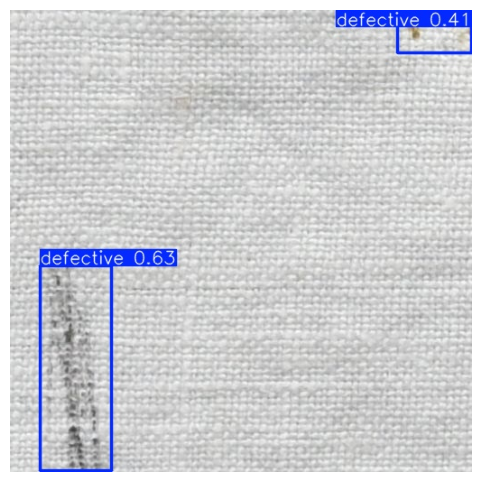

In [21]:
img_path = "/kaggle/working/runs/detect/train10/003366.jpg"
img = Image.open(img_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()


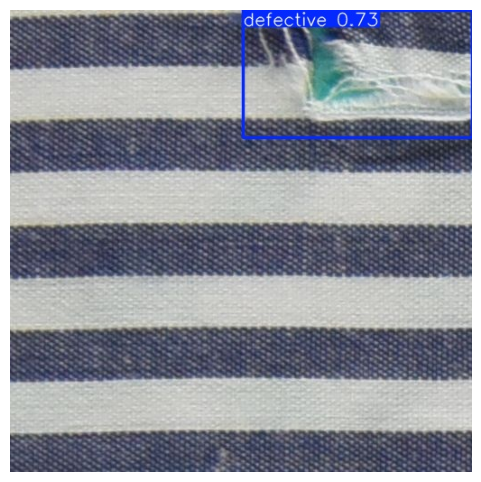

In [22]:
img_path = "/kaggle/working/runs/detect/train11/006795.jpg"
img = Image.open(img_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()


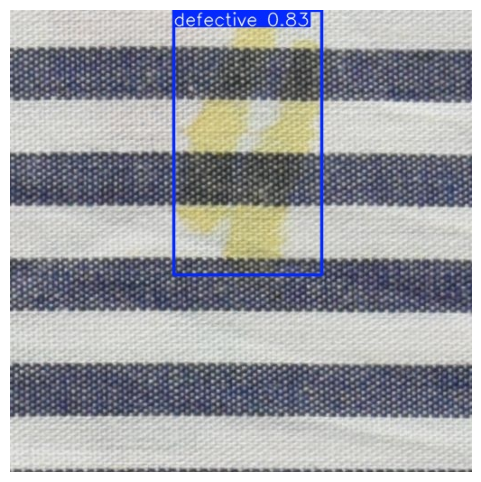

In [23]:
img_path = "/kaggle/working/runs/detect/train12/007040.jpg"
img = Image.open(img_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()


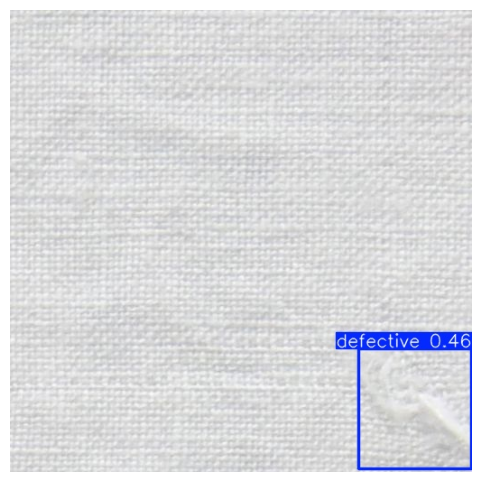

In [24]:
img_path = "/kaggle/working/runs/detect/train9/002845.jpg"
img = Image.open(img_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()


In [26]:
model.info()


Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


(72, 11125971, 0, 28.4376576)

In [27]:
print(model.model)  

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): ModuleList(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
        )
      )
    )
    (3): Conv(
      (conv): Conv2d(64

In [ ]:
import shutil

# create a ZIP of the entire /kaggle/working folder
shutil.make_archive('/kaggle/working/working', 'zip', '/kaggle/working')

print("Archive created at /kaggle/working/working.zip")
